In [76]:
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import Sampler
import numpy as np

# 参数
alpha0 = 0.25
alpha1 = 0.75
s = alpha0 + alpha1
theta = 2 * np.arccos(np.sqrt(alpha0 / s))

# 电路构建
qc = QuantumCircuit(2,1)

# Step 1: Prepare
qc.ry(theta, 0)

# Step 2: Select (ancilla=0 → X, ancilla=1 → Z)
qc.x(0)
qc.cx(0, 1)
qc.x(0)
qc.cz(0, 1)

# Step 3: Unprepare
qc.ry(-theta, 0)

# Step 4: 测量 ancilla
qc.measure(0,0)

# Run Sampler
sampler = Sampler()
job = sampler.run([qc], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

# 成功率（ancilla = 0）
success_prob = quasi_dist.get(0, 0.0)

# 理论值
s = alpha0 + alpha1
theory_success = 1 / (s ** 2)

print(f"✅ 理论成功率: {theory_success:.4f}")
print(f"✅ 实验成功率: {success_prob:.4f}")




✅ 理论成功率: 1.0000
✅ 实验成功率: 0.6199


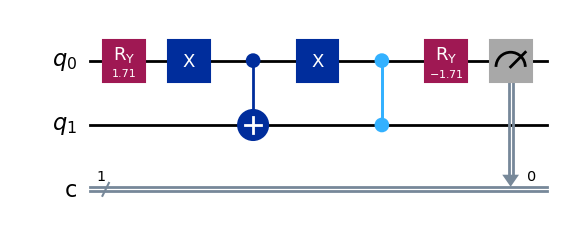

In [70]:
qc.draw('mpl')

In [77]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

# 参数
alpha0 = 0.25
alpha1 = 0.75
s = alpha0 + alpha1
theta = 2 * np.arccos(np.sqrt(alpha0 / s))

qc = QuantumCircuit(2)

# prepare
qc.ry(theta, 0)

# select block (U0=X, U1=Z)
qc.x(0)
qc.cx(0, 1)
qc.x(0)
qc.cz(0, 1)

# unprepare
qc.ry(-theta, 0)

# 初始态 |00⟩
sv = Statevector.from_label('00')
final_sv = sv.evolve(qc)

# 提取 ancilla = 0 部分（index 0,1）
v = final_sv.data
v_success = np.array([v[0], v[1]])
p_success = np.vdot(v_success, v_success).real

print(f"✅ 实验成功概率: {p_success:.4f}")
print(f"✅ 理论成功概率 (非归一化):", 1/s**2)
print(f"⚠️ 理论 1/s^2 成立的前提是：你归一化了 U_i，这里没有，因此不要用它")


✅ 实验成功概率: 0.7500
✅ 理论成功概率 (非归一化): 1.0
⚠️ 理论 1/s^2 成立的前提是：你归一化了 U_i，这里没有，因此不要用它


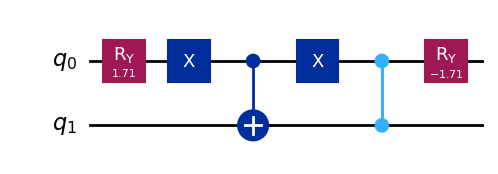

In [68]:
qc.draw('mpl')

In [64]:
v

array([ 0.57142857+0.j,  0.49487166+0.j,  0.42857143+0.j, -0.49487166+0.j])

In [66]:
v[0]**2+v[1]**2

(0.5714285714285713+0j)

In [35]:
import numpy as np
import pennylane as qml

a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")

LCU decomposition:
   (0.25) [I0 Z1]
+ (0.75) [X0 X1]
Coefficients:
 [0.25, 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]


In [36]:
np.sqrt(LCU_coeffs)

array([0.5      , 0.8660254])

In [37]:
np.linalg.norm(np.sqrt(LCU_coeffs))

0.9999999999999999

In [18]:
dev1 = qml.device("default.qubit", wires=1)

# normalized square roots of coefficients
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))


@qml.qnode(dev1)
def prep_circuit():
    qml.StatePrep(alphas, wires=0)
    return qml.state()


print("Target state: ", alphas)
print("Output state: ", np.real(prep_circuit()))

Target state:  [0.5       0.8660254]
Output state:  [0.5       0.8660254]


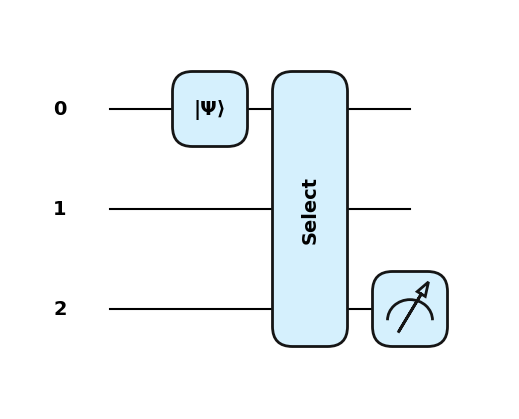

In [19]:
import matplotlib.pyplot as plt

dev2 = qml.device("default.qubit", wires=3)

# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]


@qml.qnode(dev2)
def sel_circuit(qubit_value):
    qml.BasisState(qubit_value, wires=0)
    qml.Select(unitaries, control=0)
    return qml.expval(qml.PauliZ(2))

qml.draw_mpl(sel_circuit, style='pennylane')([0])
plt.show()

In [38]:
for i, u in enumerate(unitaries):
    print(f"映射后的 op[{i}]:", u)

映射后的 op[0]: I(1) @ Z(2)
映射后的 op[1]: X(1) @ X(2)


In [20]:
print('Expectation value for input |0>:', sel_circuit([0]))
print('Expectation value for input |1>:', sel_circuit([1]))

Expectation value for input |0>: 1.0
Expectation value for input |1>: -1.0


In [21]:
@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


In [82]:
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))

proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires="ancilla")

    # SEL
    qml.Select(proj_unitaries, control="ancilla")

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires="ancilla"))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit, wire_order=["ancilla", 0])()
print("Block-encoded projector:\n")
print(np.real(np.round(output_matrix,2)))

Block-encoded projector:

[[ 1.  0. -0.  0.]
 [ 0. -0.  0. -1.]
 [-0.  0.  1.  0.]
 [ 0. -1.  0.  0.]]


In [83]:
U = output_matrix
P = U[:2, :2]
plus = np.array([1, 1]) / np.sqrt(2)
projected = P @ plus
projected /= np.linalg.norm(projected)  # 归一化
print("Projected system state (given ancilla=0):")
print(np.round(projected, 3))


Projected system state (given ancilla=0):
[ 1.+0.j -0.+0.j]


In [78]:
proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]
proj_unitaries

[I(0), Z(0)]

In [85]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

# 系数与 prepare 角度
coeffs = np.array([0.5, 0.5])
sqrt_coeffs = np.sqrt(coeffs)
alphas = sqrt_coeffs / np.linalg.norm(sqrt_coeffs)  # = [1/√2, 1/√2]
theta = 2 * np.arccos(alphas[0])  # prepare RY(theta) for ancilla

# 构造 LCU 电路
qc = QuantumCircuit(2)

# Step 1: prepare ancilla
qc.ry(theta, 0)

# Step 2: SELECT block (0→I, 1→Z)
# qc.x(0)
# qc.cx(0, 1)
qc.cz(0, 1)

# Step 3: unprepare
qc.ry(-theta, 0)

# 初始态 |00⟩
sv = Statevector.from_label('00')
final_sv = sv.evolve(qc)

# 提取 ancilla=0 部分（block-encoded projector作用后的 system 态）
v = final_sv.data
v_success = np.array([v[0], v[1]])  # ancilla=0 ⇒ indices 0,1
v_success /= np.linalg.norm(v_success)

print(f"✅ 系统态 (projected to |0⟩): {v_success}")


✅ 系统态 (projected to |0⟩): [1.+0.j 0.+0.j]


In [80]:
np.array([v[0], v[1]]) 

array([0.5+0.j, 0.5+0.j])

In [81]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

# Qiskit 计算 θ
theta = 2 * np.arccos(np.sqrt(0.6))  # ≈ 1.682

# 构建电路
qc = QuantumCircuit(1)
qc.ry(theta, 0)

# 提取 Qiskit 的 statevector
qiskit_sv = Statevector.from_instruction(qc).data
print("✅ Qiskit Statevector:", qiskit_sv)


import pennylane as qml

# 创建 PennyLane QNode
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def prep_pl():
    qml.StatePrep([np.sqrt(0.6), np.sqrt(0.4)], wires=0)
    return qml.state()

# 得到 PennyLane 的 statevector
pl_sv = prep_pl()
print("✅ PennyLane Statevector:", pl_sv)


✅ Qiskit Statevector: [0.77459667+0.j 0.63245553+0.j]
✅ PennyLane Statevector: [0.77459667+0.j 0.63245553+0.j]
